In [3]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader

from torchsummary import summary
from matplotlib import pyplot as plt

In [4]:
# В данной лабораторной работе вам предстоит реализовать и обучить автокодировочную нейронную сеть.
# В этой части в качесте данных для обучения представляются сгенерированные точки на плоскости.
# Цель в том, чтобы получить интуитивное понимание того, как автокодировщик параметризует многообразие,
# в окрестности которого располагаются точки в исходном признаковом пространстве.
# Для этого данные сначала проебразуются обученным кодировщиком, а затем докодируются обратно в исходное пространство.
# В итоге все точки лежат на параметризуемом многообразии (в данном случае, некоторой кривой на плоскости).

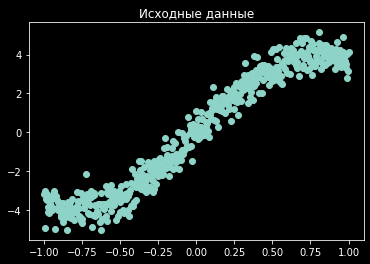

In [12]:
# Генерируем данные
x = torch.linspace(-1, 1, steps=512)
y = 4 * torch.sin(2 * x) + torch.randn(512) / 2

plt.title('Исходные данные')
plt.scatter(x, y)
plt.show()

In [25]:
# Готовим обучающие данные
train_data = torch.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
train_data_loader = DataLoader(list(zip(train_data, [torch.tensor(0)] * train_data.shape[0])), batch_size=1, shuffle=True)

In [26]:
for i in train_data_loader:
    print(i)
    break

[tensor([[0.5264, 4.3109]]), tensor([0])]


In [39]:
class Encoder(nn.Module):
    # Класс кодировщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.encoder = nn.Sequential(
            nn.Linear(inputs, 8),
            nn.Tanh(),
            nn.Linear(8, 4),
            nn.Tanh(),
            nn.Linear(4, latent_size),
            # nn.Tanh(),
        )
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = self.encoder(x)
        # ============
        return x


class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 4),
            nn.Tanh(),
            nn.Linear(4, 8),
            nn.Tanh(),
            nn.Linear(8, outputs)
        )
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = self.decoder(x)
        # ============
        return x

In [40]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    loss_history = list()

    loss_func = nn.MSELoss()  # функция потерь, нужно выбрать.
    optimizer = torch.optim.AdamW(chain(decoder.parameters(), encoder.parameters()))  # оптимизатор, нужно выбрать.

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch = batch.reshape(batch.shape[0], -1)
            # print(batch)
            optimizer.zero_grad()
            forwd = encoder(batch)
            loss = loss_func(decoder(forwd), batch) # потери на пакете, нужно вычислить.
            loss.backward()
            optimizer.step()
            # ============
            loss_history.append(loss.log().item())
        if((epoch + 1) % 100 == 0):
          print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

Эпоха 100 / 500. Потери на последнем пакете: 0.048842236399650574
Эпоха 200 / 500. Потери на последнем пакете: 0.04996870085597038
Эпоха 300 / 500. Потери на последнем пакете: 0.005670985672622919
Эпоха 400 / 500. Потери на последнем пакете: 0.05579475685954094
Эпоха 500 / 500. Потери на последнем пакете: 0.0025915999431163073


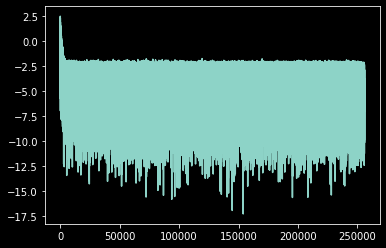

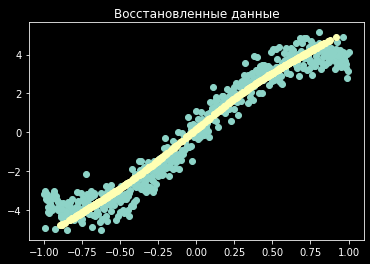

In [41]:
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

# Обучаем автокодировщик
train_ae(train_data_loader, encoder, decoder, 500, 5e-5)

# Прогоняем данные через автокодировщик
restored_data = decoder(encoder(train_data))

# Отображаем результат
plt.title('Восстановленные данные')
plt.scatter(x, y)
plt.scatter(*zip(*restored_data.detach().numpy()))
plt.show()